In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import SVD, KNNBasic, NMF, SlopeOne, CoClustering
from surprise.accuracy import rmse, mae, mse

In [16]:
df_ratings = pd.read_csv("ratings.csv")
df_ratings_small = pd.read_csv("ratings_small.csv")

df_metadata = pd.read_csv("movies_metadata.csv", low_memory=False)
df_metadata_small = pd.read_csv("movies_metadata_small.csv")

In [4]:
print("Full Dataset Size: ", df_ratings.shape)
print("Small Dataset Size: ", df_ratings_small.shape)

Full Dataset Size:  (26024289, 4)
Small Dataset Size:  (100004, 4)


In [17]:
print("Full Metadata Size: ", df_metadata.shape)
print("Small Metadata Size: ", df_metadata_small.shape)

Full Metadata Size:  (45466, 24)
Small Metadata Size:  (9099, 25)


In [5]:
df_ratings_small.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [40]:
# Checking movies with different orginal_title and titles

df_metadata_small[df_metadata_small["original_title"] != df_metadata_small["title"]][["original_title", "title"]].head()

# Decided to go with "title"

,original_title,title
28,La Cité des Enfants Perdus,The City of Lost Children
29,摇啊摇，摇到外婆桥,Shanghai Triad
54,Il postino,The Postman
55,Le confessionnal,The Confessional
63,Gazon maudit,French Twist


In [18]:
df_metadata = df_metadata[["id", "title"]]

df_metadata.head()

,id,title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [24]:
df_metadata['id'] = pd.to_numeric(df_metadata['id'], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      45463 non-null  float64
 1   title   45460 non-null  object 
dtypes: float64(1), object(1)
memory usage: 710.5+ KB


In [25]:
# Joining the datasets

df = pd.merge(df_ratings_small, df_metadata,
              left_on="movieId", right_on="id", how="left")

In [35]:
df.drop(columns=["id", "timestamp"], inplace=True)

df.head()

,userId,movieId,rating,title
0,1,31,2.5,NaN
1,1,1029,3.0,NaN
2,1,1061,3.0,NaN
3,1,1129,2.0,NaN
4,1,1172,4.0,NaN


In [37]:
percent_empty = round(df[pd.isna(df["title"])].shape[0] / df.shape[0] * 100, 2)

print("Percent of movies with no title metadata: ", percent_empty)

Percent of movies with no title metadata:  55.01


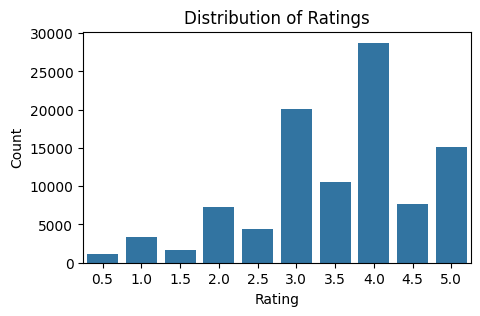

In [39]:
plt.figure(figsize=(5, 3))
sns.countplot(x='rating', data=df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [42]:
df_copy = df.copy()


min_rating = df_copy['rating'].min()
max_rating = df_copy['rating'].max()

reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(df_copy[['userId','movieId','rating']], reader)


trainset, testset = train_test_split(data, test_size=0.20)

algos = [SVD(), KNNBasic(), NMF(), SlopeOne(), CoClustering()]


cv_results_list = []

for algo in algos:
    print(f'\nAlgorithm: {algo.__class__.__name__}')
    cv_results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    print(f'RMSE: {cv_results["test_rmse"].mean()}')
    print(f'MAE: {cv_results["test_mae"].mean()}')
    cv_results_list.append(cv_results)




Algorithm: SVD
RMSE: 0.8966164734433105
MAE: 0.6902166599784841

Algorithm: KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9683610214422804
MAE: 0.7444193673503952

Algorithm: NMF
RMSE: 0.9466469088771575
MAE: 0.726275059007377

Algorithm: SlopeOne
RMSE: 0.9301311510503789
MAE: 0.7122275903774502

Algorithm: CoClustering
RMSE: 0.9662871186145537
MAE: 0.7480955340667983


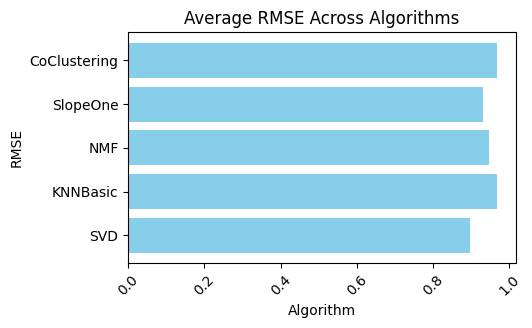

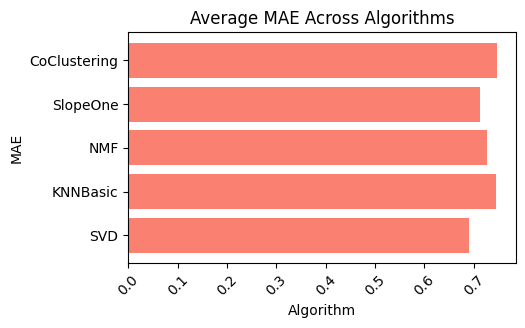

In [43]:
# Visualizing algorithm performance metrics
alg_names = [algo.__class__.__name__ for algo in algos]
rmse_scores = [cv_results['test_rmse'].mean() for cv_results in cv_results_list]
mae_scores = [cv_results['test_mae'].mean() for cv_results in cv_results_list]

plt.figure(figsize=(5, 3))
plt.barh(alg_names, rmse_scores, color='skyblue')
plt.title('Average RMSE Across Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(5, 3))
plt.barh(alg_names, mae_scores, color='salmon')
plt.title('Average MAE Across Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.show()

**There's not much of a difference between the metrics for models, if we exclude SVD since it is a matrix-based model but we can go with that too.**

# Item-Based KNN

In [49]:
knn_basic = KNNBasic(sim_options={'user_based': False}) # Item-based
knn_basic.fit(trainset)

predictions_knn = knn_basic.test(testset) # 20% split

mse(predictions_knn)
rmse(predictions_knn)
mae(predictions_knn)

Computing the msd similarity matrix...
Done computing similarity matrix.
MSE: 0.8757
RMSE: 0.9358
MAE:  0.7209


0.7208795494153186

## Fine-tune

### Grid-Search

In [72]:
param_grid = {'sim_options': {'name': ['cosine', 'msd', 'pearson'],
                              'user_based': [True, False]},
              'k': [20, 40, 60],
              'min_k': [1, 2, 5],
              'shrinkage': [10, 20, 30]}

grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5)
grid_search.fit(data)

best_params = grid_search.best_params

best_params

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

{'rmse': {'sim_options': {'name': 'msd', 'user_based': False},
  'k': 60,
  'min_k': 5,
  'shrinkage': 10},
 'mae': {'sim_options': {'name': 'msd', 'user_based': False},
  'k': 60,
  'min_k': 5,
  'shrinkage': 10}}

'rmse': {'sim_options': {'name': 'msd', 'user_based': False},
  'k': 60,
  'min_k': 5,
  'shrinkage': 10},
 'mae': {'sim_options': {'name': 'msd', 'user_based': False},
  'k': 60,
  'min_k': 5,
  'shrinkage': 10}}

In [79]:
sim_options = {
    'name': 'msd',  
    'user_based': False
}

best_knn = KNNBasic(sim_options=sim_options, k=60, min_k=5, shrinkage=10)
best_knn.fit(trainset)

best_knn_predictions = best_knn.test(testset)

mse(best_knn_predictions)
rmse(best_knn_predictions)
mae(best_knn_predictions)



Computing the msd similarity matrix...
Done computing similarity matrix.
MSE: 0.8693
RMSE: 0.9323
MAE:  0.7177


0.7177010186591153

# Matrix-Based SVD

In [50]:
svd = SVD()


svd.fit(trainset)

predictions_svd = svd.test(testset)

mse(predictions_svd)
rmse(predictions_svd)
mae(predictions_svd)

MSE: 0.8040
RMSE: 0.8967
MAE:  0.6897


0.6897007656394731

## Fine-Tune

In [75]:
# Define the parameter grid for grid search
param_grid = {'n_factors': [50, 100, 150],
              'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.02, 0.1, 0.2]}

# Initialize the SVD algorithm
svd = SVD()

# Perform grid search with cross-validation
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
grid_search.fit(data)

# Get the best parameters
best_params = grid_search.best_params


In [76]:
best_params

{'rmse': {'n_factors': 150, 'lr_all': 0.01, 'reg_all': 0.1},
 'mae': {'n_factors': 150, 'lr_all': 0.01, 'reg_all': 0.1}}

In [80]:
best_svd = SVD(n_factors=150, lr_all=0.01, reg_all=0.1)

best_svd.fit(trainset)

best_svd_predictions = best_svd.test(testset)

mse(best_svd_predictions)
rmse(best_svd_predictions)
mae(best_svd_predictions)


MSE: 0.7829
RMSE: 0.8848
MAE:  0.6813


0.6812722187439663

# Examples

### Top 5 Recommendations for User 292

In [95]:
# Specify the user for whom you want recommendations
target_user_id = 292 

# Find items the user has already rated
rated_items = df[df['userId'] == target_user_id]['movieId'].unique()

# Find similar items using the trained model
similar_items = []
for item_id in rated_items:
    item_inner_id = trainset.to_inner_iid(item_id)
    similar_items.extend(best_knn.get_neighbors(item_inner_id, k=5))

# Exclude items the user has already rated
similar_items = [trainset.to_raw_iid(inner_id) for inner_id in similar_items if trainset.to_raw_iid(inner_id) not in rated_items]

# Generate recommendations for the user
recommendations = []
for item_id in similar_items:
    estimated_rating = best_knn.predict(uid=target_user_id, iid=item_id).est
    recommendations.append({'user': target_user_id, 'item': item_id, 'estimated_rating': estimated_rating})

# Sort recommendations by estimated rating in descending order
sorted_recommendations = sorted(recommendations, key=lambda x: x['estimated_rating'], reverse=True)

# Display the top 5 recommendations
top_5_recommendations = sorted_recommendations[:5]
for recommendation in top_5_recommendations:
    print(f"User: {recommendation['user']}, MovieID: {recommendation['item']}, Estimated Rating: {recommendation['estimated_rating']}")

User: 292, MovieID: 8121, Estimated Rating: 4.365886567577586
User: 292, MovieID: 8121, Estimated Rating: 4.365886567577586
User: 292, MovieID: 55069, Estimated Rating: 4.2970825710175005
User: 292, MovieID: 104283, Estimated Rating: 4.248247133547803
User: 292, MovieID: 104283, Estimated Rating: 4.248247133547803
